In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
#fpath = "../code/data/DNN_data/"

sig_with_artifact = np.load("data_with_artifact_test" + ".npy")
sig = np.load("data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


(4000,)


Text(0.5, 1.0, 'Original Signal')

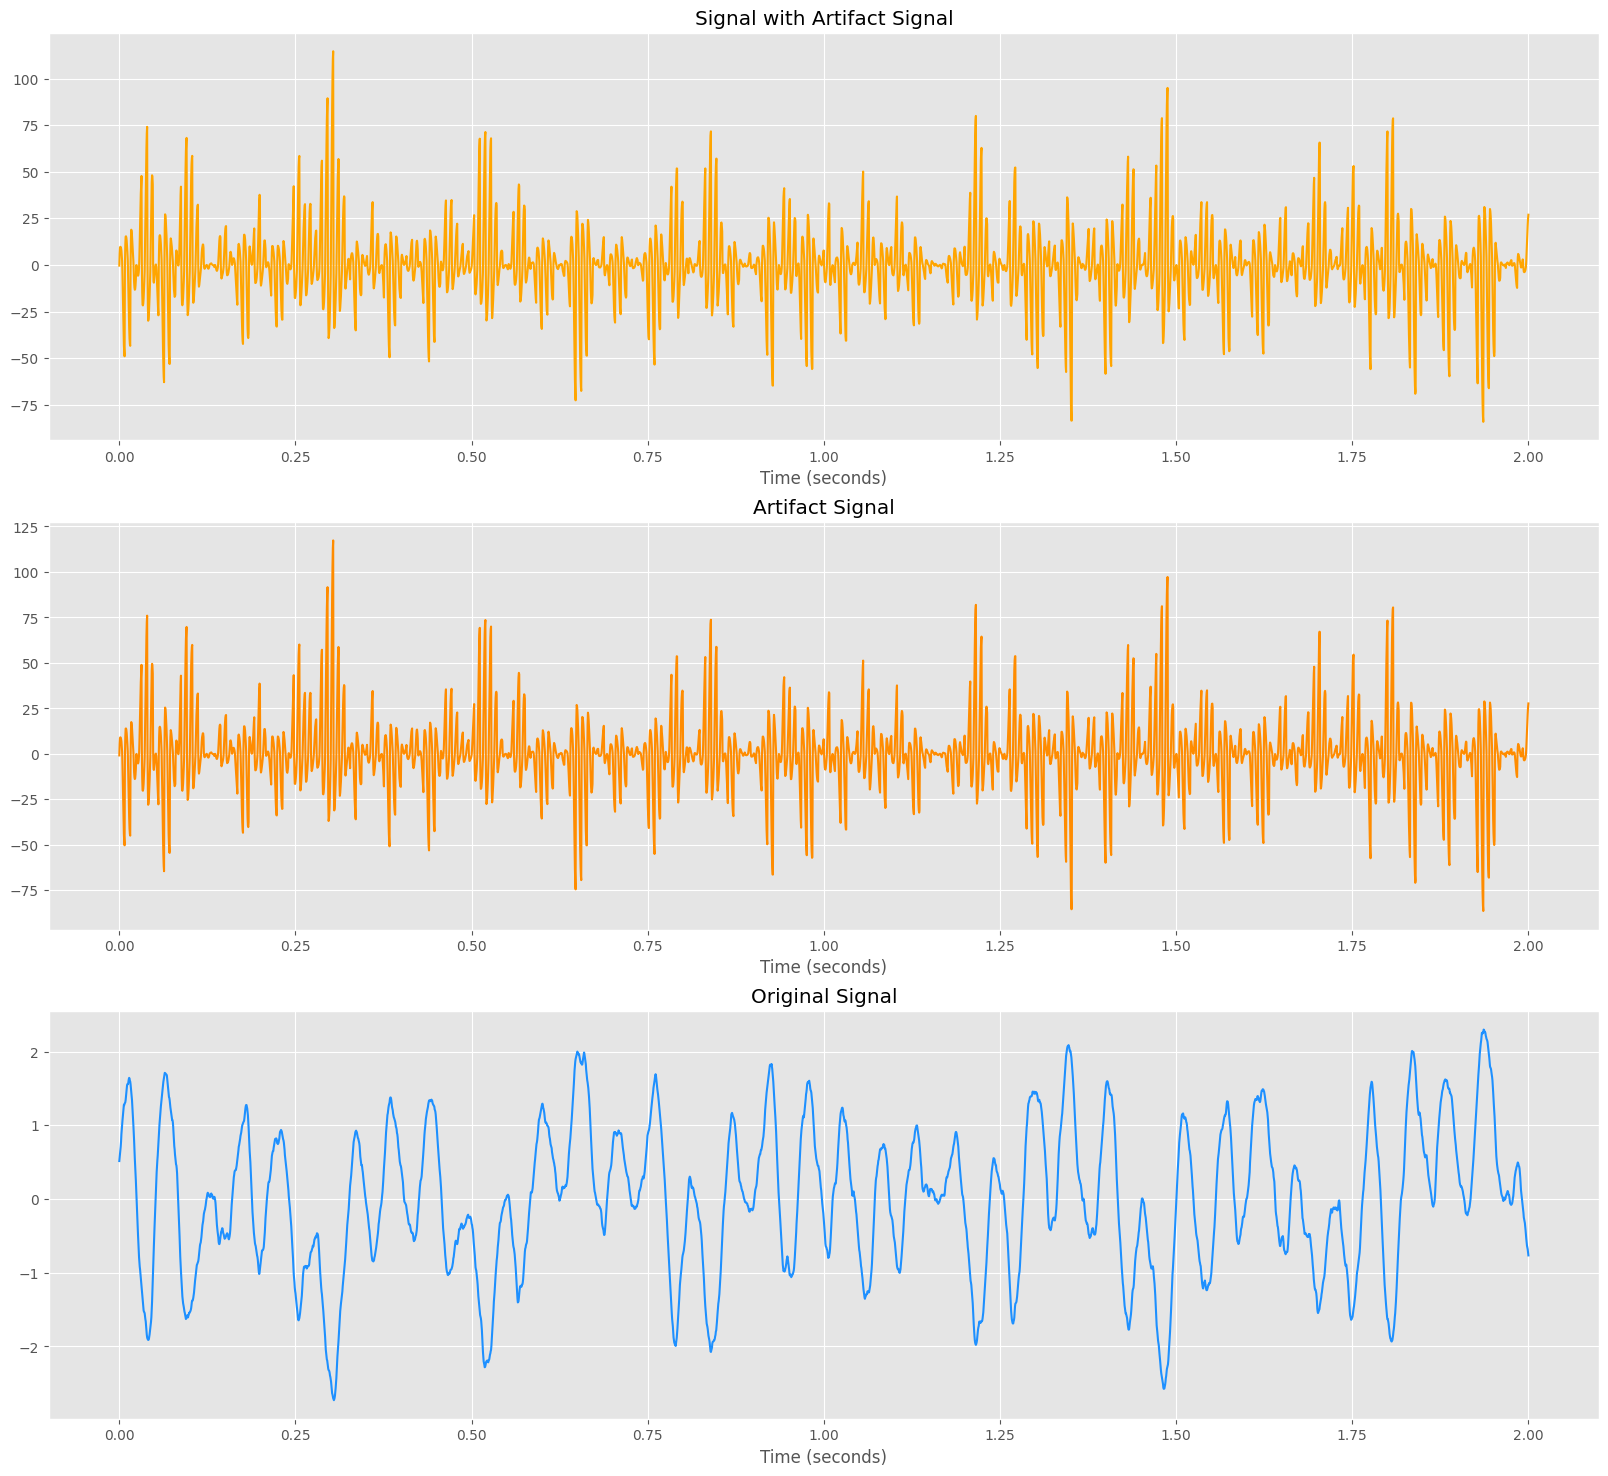

In [29]:
t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20,18))
plt.subplot(3, 1, 1)
plt.plot(t, sig_with_artifact[0], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t, artifact[0], color='darkorange')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t, sig[0], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

In [45]:
sig_with_artifact = sig_with_artifact.transpose()
sig = sig.transpose()
print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)
(4000,)


(1000, 4000)
(1000, 4000)


(-3.0, 3.0)

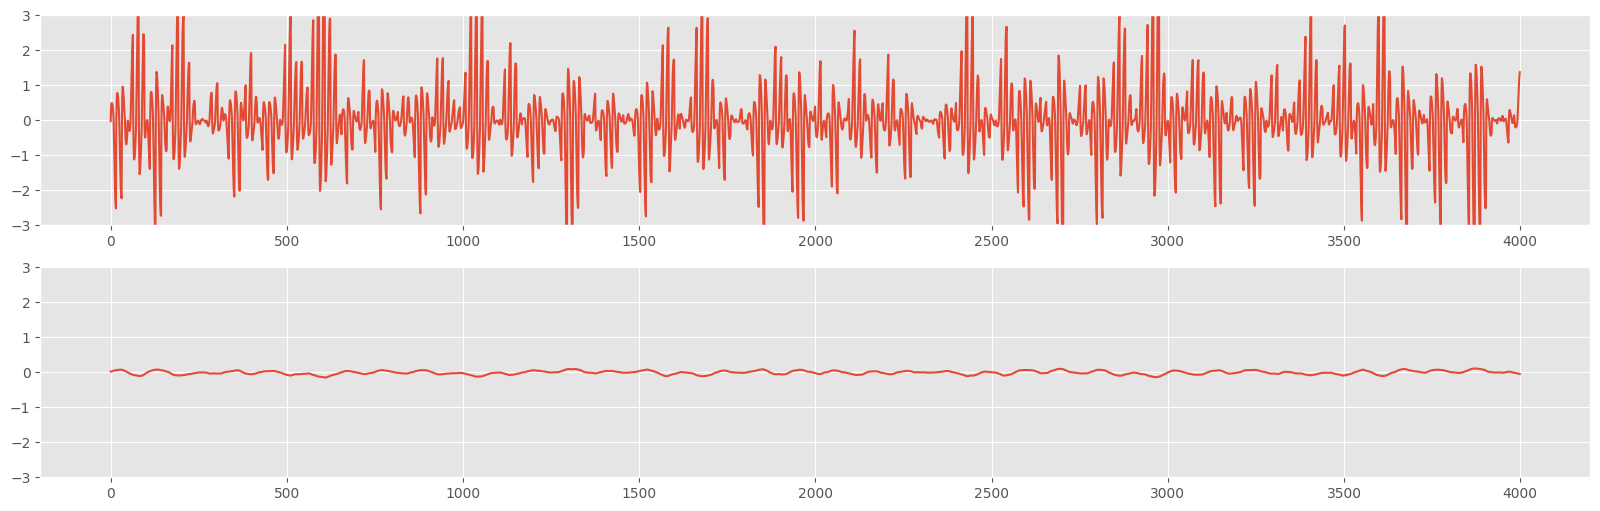

In [31]:
# StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(sig_with_artifact)
y = (sig-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

X = X.transpose()
y = y.transpose()

print(X.shape)
print(y.shape)

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(X[0])
plt.ylim([-3, 3])
plt.subplot(2, 1, 2)
plt.plot(y[0])
plt.ylim([-3, 3])

In [32]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

X_train = X_train.reshape(X_train.shape[0], 1, 4000)
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("<unsqueezed>")
print("-----------------------------")
print("X_train shape: {}\ny_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("-----------------------------")
print("X_test shape: {}\ny_test shape: {}".format(X_test.shape, y_test.shape))
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<unsqueezed>
-----------------------------
X_train shape: (800, 1, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 1, 4000)
y_test shape: (200, 4000)
-----------------------------


In [33]:
##setting variables##
batch_size = 32
epochs = 5
sample_size = 4000
nz = 128
k = 1

In [34]:
##generator##
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
        nn.Linear(self.nz,256),
        nn.LeakyReLU(0.2),
        nn.Linear(256,512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,4000),
        nn.Tanh(),
        )
    def forward(self,x):
        return self.main(x) #return value = size of batch*1*28*28

In [35]:
##discriminator##
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 4000
        self.main = nn.Sequential(
            nn.Linear(self.n_input,1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        x = x.view(-1, self.n_input)
        return self.main(x) # return whether the image is real or fake

In [36]:
##initialize the generator and discriminator network##
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=4000, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4000, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [37]:
##define optimizer and loss function##
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [38]:
##define function to save the generator image##
def save_generator_image(image, path):
    save_image(image, path)

In [39]:
##train discriminator##
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size,1).to(device)
    fake_label = torch.zeros(b_size,1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake= criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [40]:
##train generator##
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size,1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [41]:
##train model##
generated_data_all = []
data_real_all = []

generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        data_real, _ = data
        data_real = data_real.view(-1,4000).to(device)
        b_size = data_real.size(0)
        for step in range(k):
            z = torch.randn((b_size, nz)).to(device)
            data_fake = generator(z).detach()
            loss_d += train_discriminator(optim_d, data_real, data_fake)

        data_fake = generator(torch.randn((b_size, nz)).to(device))
        loss_g += train_generator(optim_g, data_fake)

    #generated_data = generator(torch.randn((b_size, nz)).to(device)).cpu().detach()
    #save_generator_image(generated_data, f"./img/gen_img{epoch}.png")
    #images.append(generated_data)
    epoch_loss_g = loss_g/idx
    epoch_loss_d = loss_d/idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    if epoch == epochs -1:
      generated_data_all.append(data_fake.cpu().detach().numpy())
      data_real_all.append(data_real.cpu().detach().numpy())

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

100%|██████████| 16/16 [00:00<00:00, 78.37it/s]


Epoch 0 of 5
Generator loss: 0.63638979, Discriminator loss: 1.11164725


100%|██████████| 16/16 [00:00<00:00, 96.34it/s]


Epoch 1 of 5
Generator loss: 1.05592632, Discriminator loss: 1.20295167


100%|██████████| 16/16 [00:00<00:00, 97.76it/s]


Epoch 2 of 5
Generator loss: 1.86333752, Discriminator loss: 0.59314430


100%|██████████| 16/16 [00:00<00:00, 106.59it/s]


Epoch 3 of 5
Generator loss: 1.78198612, Discriminator loss: 0.59587824


100%|██████████| 16/16 [00:00<00:00, 99.28it/s] 

Epoch 4 of 5
Generator loss: 1.80002987, Discriminator loss: 0.44206238


(1000, 4000)


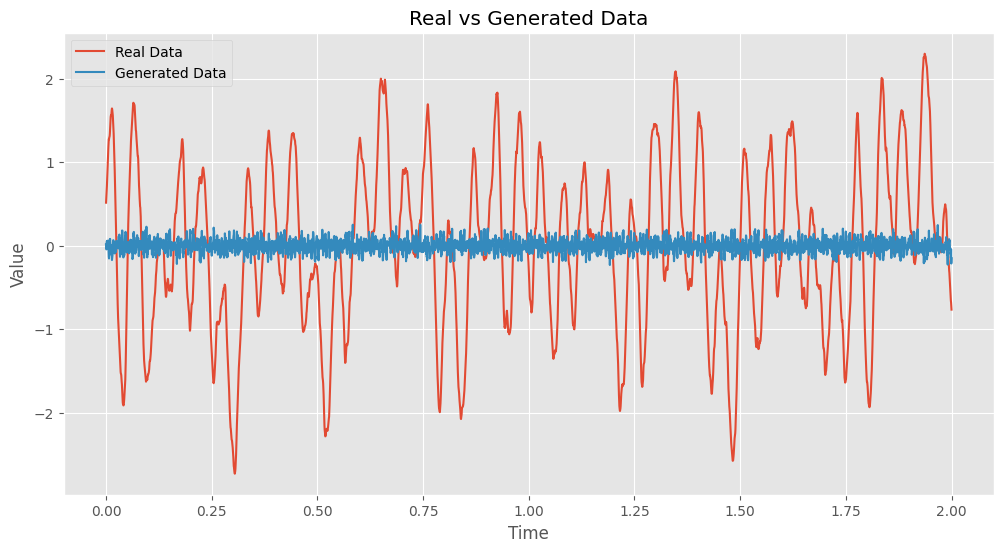

In [47]:
import matplotlib.pyplot as plt

generated_data_example = generated_data_all[0][0]
real_data_example = data_real_all[0][0]
print(sig.shape)
plt.figure(figsize=(12, 6))
plt.plot(t, sig[0], label="Real Data")
plt.plot(t, generated_data_example, label="Generated Data")
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Real vs Generated Data')
plt.legend()
plt.show()

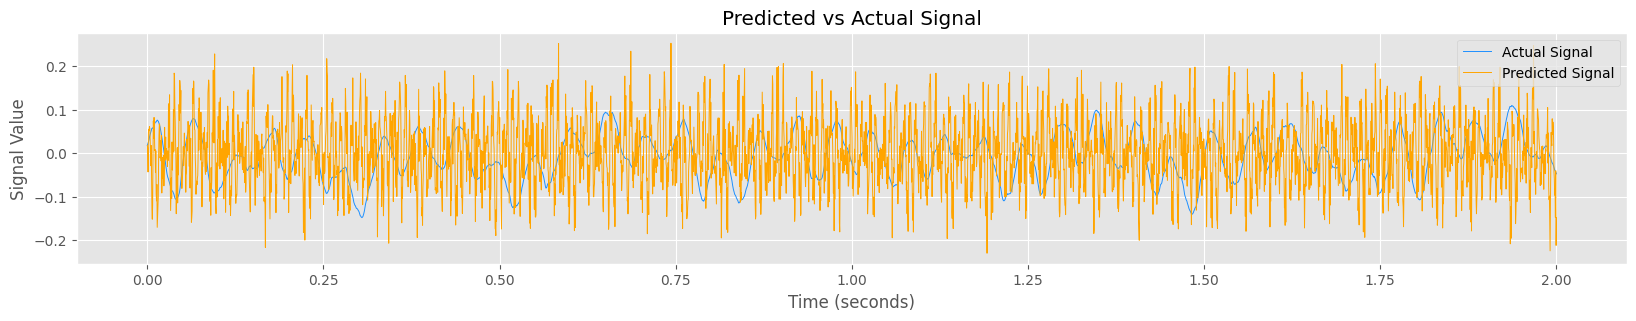

Mean Absolute Error: 0.07507157558054225
Mean Squared Error: 0.009470250464963456


In [52]:
# time domain plotting

predicted_signal = generated_data_example
actual_signal = y[0]

t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20, 3))
plt.plot(t, actual_signal, label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(t, predicted_signal, label='Predicted Signal', color='orange', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

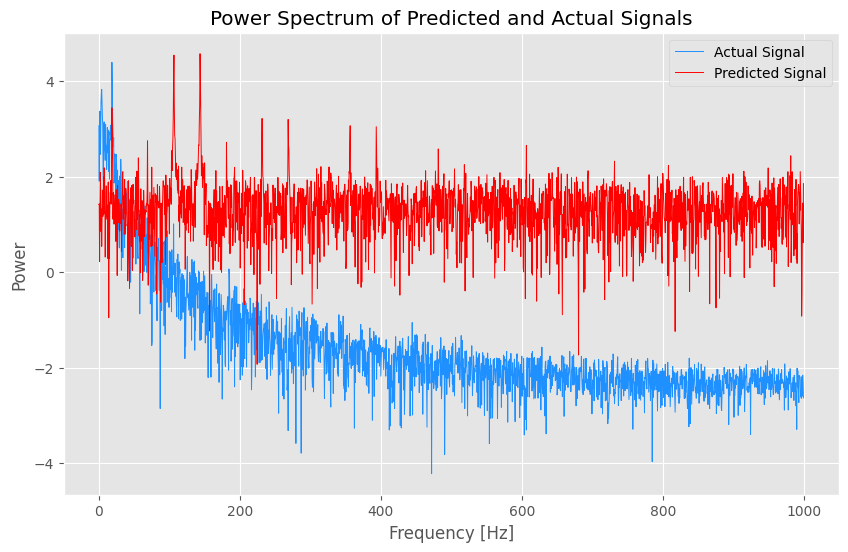

Mean Absolute Error: 2.961421461459177
Mean Squared Error: 9.825168381139154


In [51]:
# frequency domain plotting

n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='red', alpha=1, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")